Let's create a simple feedforward neural network using TensorFlow to solve a regression problem. I'll start by creating synthetic data, then define, train, and evaluate the neural network using backpropagation.

1. Creating Synthetic Data:

In [1]:
import numpy as np
import tensorflow as tf

# Generate synthetic data
np.random.seed(42)
X = np.linspace(-1, 1, 100)[:, np.newaxis]
y = 2 * X + 1 + 0.5 * np.random.normal(size=X.shape)

# Splitting the data into training and test sets
train_indices = np.random.choice(len(X), round(len(X) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(X))) - set(train_indices)))
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]


2. Building the Neural Network:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a sequential model
model = Sequential()

# Adding layers to the model
model.add(Dense(10, input_dim=1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


3. Training the Model:

In [3]:
model.fit(X_train, y_train, epochs=100, batch_size=10)


Epoch 1/100
8/8 [==============================] - 2s 4ms/step - loss: 2.4610
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 2.4268
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 2.3934
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 2.3536
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.3051
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 2.2428
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 2.1795
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 2.1108
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 2.0348
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 1.9603
Epoch 11/100
8/8 [==============================] - 0s 8ms/step - loss: 1.8752
Epoch 12/100
8/8 [==============================] - 0s 7ms/step - loss: 1.7929
Epoch 13/100
8/8 [==============================] - 0s 4ms/st

4. Evaluating the Model:

In [4]:
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {loss}")


1/1 [==============================] - 1s 751ms/step - loss: 0.1365
Mean Squared Error: 0.1364605873823166


5. Predicting using the Model:

1/1 [==============================] - 0s 387ms/step


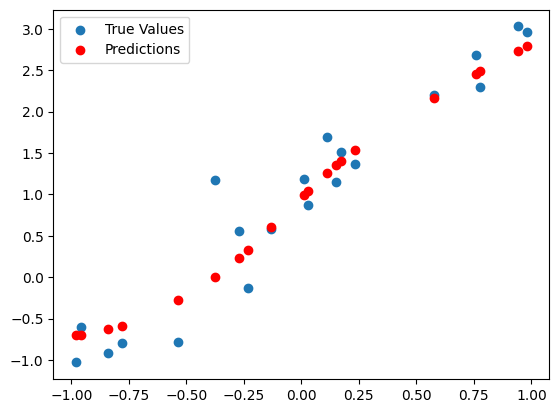

In [5]:
y_pred = model.predict(X_test)

# Optionally, you can plot the results
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, label="True Values")
plt.scatter(X_test, y_pred, label="Predictions", color='red')
plt.legend()
plt.show()


Translating a neural network model directly to Cairo is nontrivial and operating with neural networks in such a space requires various specialized strategies.

However, a high-level guideline of steps that would be involved:

1. **Data Representation**: You would need to represent neural network weights, biases, and activations as fixed-point numbers or integers.

2. **Linear Layers**: You would need to manually implement matrix multiplication and bias addition in Cairo.

3. **Activation Functions**: Activation functions like ReLU would need to be implemented manually. For ReLU, you would compare the value against 0 and choose the maximum.

4. **Loss Calculation**: The loss function, such as mean squared error, would need to be manually computed in Cairo for each output against the true label.

5. **Backpropagation**: This is the trickiest part. We have to manually implement the backpropagation algorithm in Cairo, which means computing gradients for each weight and updating the weights accordingly.

6. **Optimization**: For each epoch, we feed the data through the network, compute the loss, backpropagate to compute gradients, and then update the weights.

However, the most challenging part of the entire process would be managing memory, handling loops, and ensuring efficient operations in Cairo, which is quite low-level.

In [7]:
import os
tensor_name =['X_values', 'Y_values']

def generate_cairo_files(data, name):

    os.makedirs('src/generated', exist_ok=True)
    with open(os.path.join('src', 'generated', f"{name}.cairo"), "w") as f:
            f.write(
                "use array::ArrayTrait;\n" +
                "use orion::operators::tensor::core::{TensorTrait, Tensor, ExtraParams};\n" +
                "use orion::operators::tensor::implementations::impl_tensor_fp::Tensor_fp;\n" +
                "use orion::numbers::fixed_point::core::{FixedTrait, FixedType, FixedImpl};\n"
                "use orion::numbers::fixed_point::implementations::fp16x16::core::{FP16x16Impl, FP16x16PartialEq };\n"+
                "fn {0}() -> Tensor<FixedType>  ".format(name) + "{\n" +
                "    let mut shape = ArrayTrait::new();\n"
            )
            for dim in data.shape:
                f.write("    shape.append({0});\n".format(dim))
            f.write(
                "    let mut data = ArrayTrait::new();\n"
            )
            for val in np.nditer(data.flatten()):
                f.write("    data.append(FixedTrait::new({0}, {1} ));\n".format(abs(int(val * 2**16)), str(val < 0).lower()))
            f.write(
                "let extra = ExtraParams { fixed_point: Option::Some(FixedImpl::FP16x16(())) }; \n" +
                "let tensor = TensorTrait::<FixedType>::new(shape.span(), data.span(), Option::Some(extra)); \n \n" +
                "return tensor;\n\n"+
                "}\n"
            )
    with open(os.path.join('src', 'generated.cairo'), 'w') as f:
        for param_name in tensor_name:
            f.write(f"mod {param_name};\n")


generate_cairo_files(X, 'X_values')
generate_cairo_files(y, 'Y_values')